In [1]:
!pip install monai==0.7.0

!pip install monai tqdm
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!pip install self-attention-cv==1.2.3
%matplotlib inline

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch

print_config()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.2/650.2 kB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
root_dir = './'
print(root_dir)
set_determinism(seed=0)

class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

./


In [3]:
roi_size=[128, 128, 64]
pixdim=(1.5, 1.5, 2.0)

train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pixdim,
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=roi_size, random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=pixdim,
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=roi_size),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

In [4]:
!pip install -q "monai-weekly[nibabel, tqdm]"
cache_num = 8

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    num_workers=4,
    cache_num=cache_num, # it was 100 but we use larger volumes
    cache_rate=0.01
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=cache_num,
    cache_rate=0.01
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.4 MB/s eta 0:00:00


Task01_BrainTumour.tar: 7.09GB [03:31, 35.9MB/s]                            


Downloaded: ./Task01_BrainTumour.tar
Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
Writing into directory: ./.


Loading dataset: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


In [5]:
import numpy as np
from torch.utils.data import DataLoader
# Manually filter 0.01 of the data
train_size = int(len(train_ds) * 1)
val_size = int(len(val_ds) * 1)

train_indices = np.random.choice(len(train_ds), train_size, replace=False)
val_indices = np.random.choice(len(val_ds), val_size, replace=False)

train_subset = torch.utils.data.Subset(train_ds, train_indices)
val_subset = torch.utils.data.Subset(val_ds, val_indices)

train_loader = DataLoader(train_subset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=2, shuffle=False, num_workers=2)

image shape: torch.Size([4, 128, 128, 64])


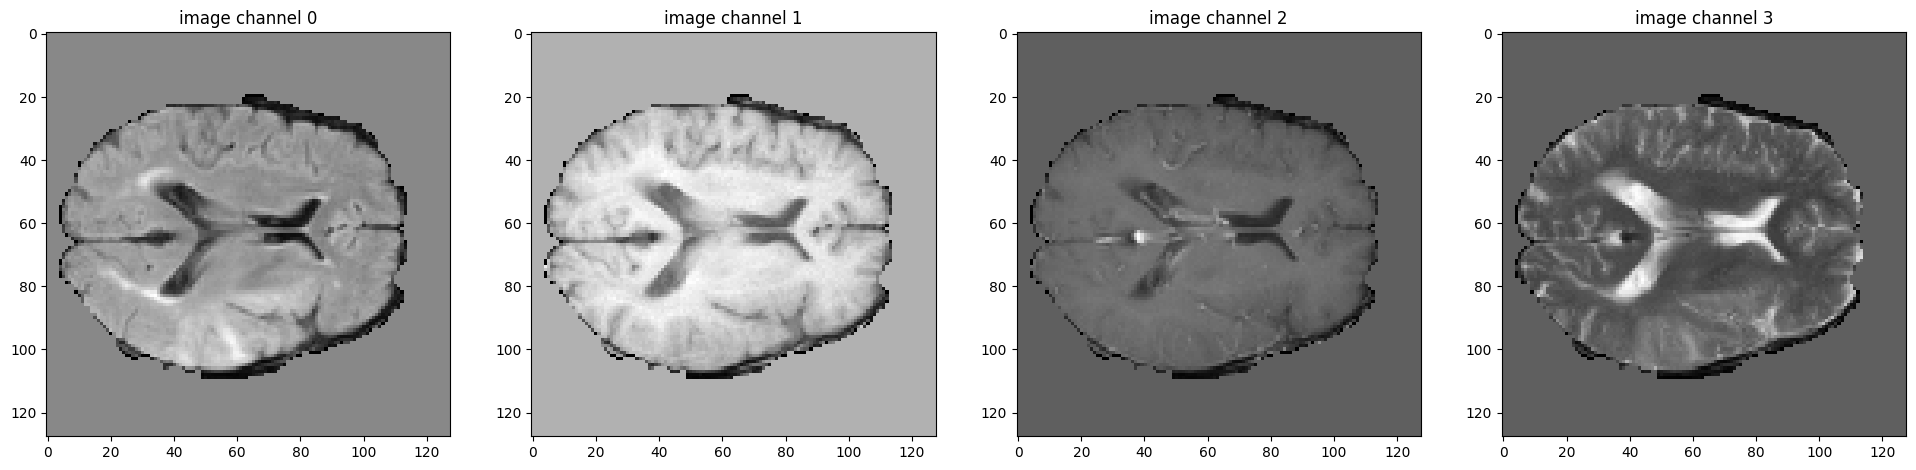

label shape: torch.Size([3, 128, 128, 64])


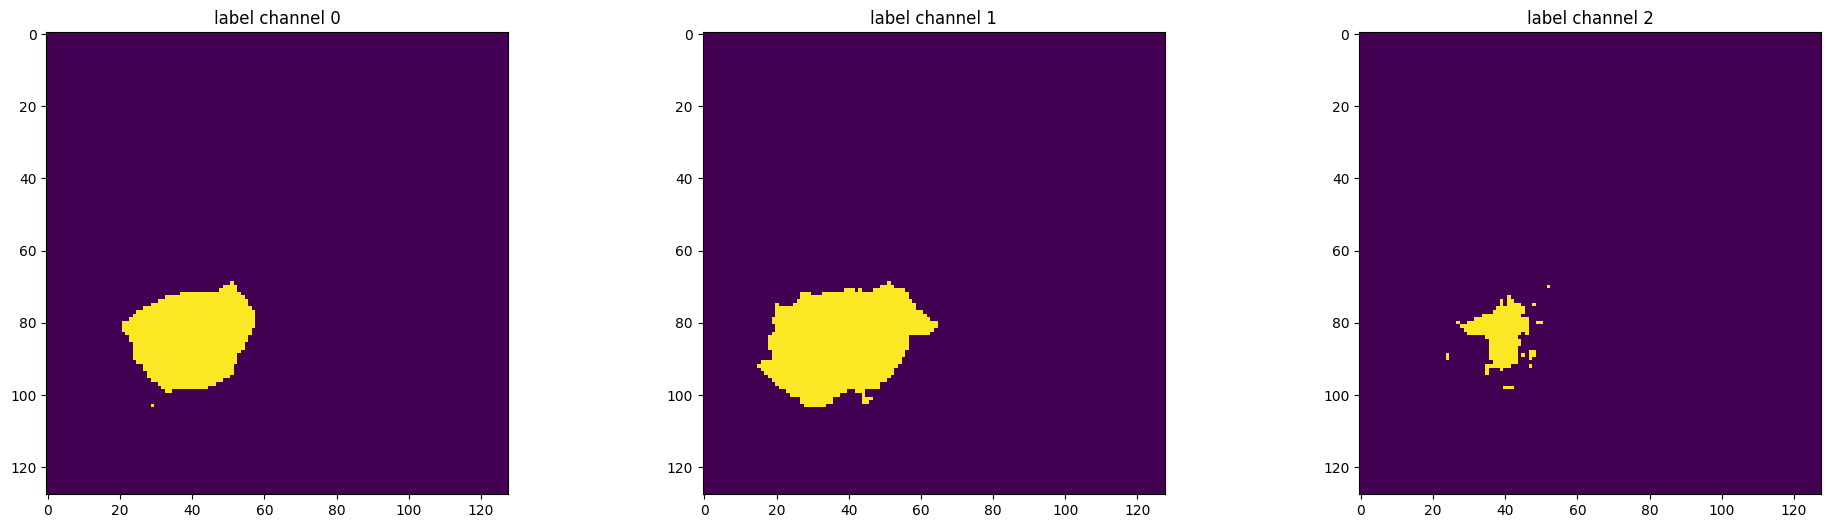

(128, 128, 64)


In [6]:
slice_id = 32
# pick one image from DecathlonDataset to visualize and check the 4 channels
print(f"image shape: {val_ds[2]['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_ds[2]["image"][i, :, :, slice_id].detach().cpu(),  cmap="gray") #
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_ds[2]['label'].shape}")
plt.figure("label", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_ds[6]["label"][i, :, :, slice_id].detach().cpu())
plt.show()

train_size = tuple(val_ds[6]['image'].shape[1:])
print(train_size)

In [ ]:
# import torch.nn as nn
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, dim, heads, dim_head):
#         super().__init__()
#         self.heads = heads
#         self.dim_head = dim if dim_head is None else dim_head
#         self.scale = self.dim_head ** -0.5

#         self.to_qkv = nn.Linear(dim, self.dim_head * heads * 3, bias=False)
#         self.to_out = nn.Linear(self.dim_head * heads, dim)

#     def forward(self, x, mask=None):
#         b, n, _, h = *x.shape, self.heads
#         qkv = self.to_qkv(x).chunk(3, dim=-1)
#         q, k, v = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2), qkv)

#         dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale

#         if mask is not None:
#             dots.masked_fill_(mask == 0, float('-inf'))
#         attn = dots.softmax(dim=-1)

#         out = torch.matmul(attn, v)
#         out = out.transpose(1, 2).reshape(b, n, -1)
#         return self.to_out(out)
# class TransformerBlock(nn.Module):
#     """
#     Vanilla transformer block from the original paper "Attention is all you need"
#     Detailed analysis: https://theaisummer.com/transformer/
#     """

#     def __init__(self, dim, heads=8, dim_head=None,
#                  dim_linear_block=1024, dropout=0.1, activation=nn.GELU,
#                  mhsa=None, prenorm=False):
#         """
#         Args:
#             dim: token's vector length
#             heads: number of heads
#             dim_head: if none dim/heads is used
#             dim_linear_block: the inner projection dim
#             dropout: probability of droppping values
#             mhsa: if provided you can change the vanilla self-attention block
#             prenorm: if the layer norm will be applied before the mhsa or after
#         """
#         super().__init__()
#         self.mhsa = mhsa if mhsa is not None else MultiHeadSelfAttention(dim=dim, heads=heads, dim_head=dim_head)
#         self.prenorm = prenorm
#         self.drop = nn.Dropout(dropout)
#         self.norm_1 = nn.LayerNorm(dim)
#         self.norm_2 = nn.LayerNorm(dim)

#         self.linear = nn.Sequential(
#             nn.Linear(dim, dim_linear_block),
#             activation(),  # nn.ReLU or nn.GELU
#             nn.Dropout(dropout),
#             nn.Linear(dim_linear_block, dim),
#             nn.Dropout(dropout)
#         )

#     def forward(self, x, mask=None):
#         if self.prenorm:
#             y = self.drop(self.mhsa(self.norm_1(x), mask)) + x
#             out = self.linear(self.norm_2(y)) + y
#         else:
#             y = self.norm_1(self.drop(self.mhsa(x, mask)) + x)
#             out = self.norm_2(self.linear(y) + y)
#         return out


In [14]:
import torch
import torch.nn as nn
from einops import rearrange

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, heads, dim_head=None, scale=None):
        super().__init__()
        self.heads = heads
        self.dim_head = (dim // heads) if dim_head is None else dim_head
        self.scale = scale if scale is not None else (self.dim_head ** -0.5)

        self.to_qkv = nn.Linear(dim, self.dim_head * heads * 3, bias=False)
        self.to_out = nn.Linear(self.dim_head * heads, dim)

    def forward(self, x, mask=None):
        b, n, _ = x.shape
        qkv = self.to_qkv(x)
        qkv = rearrange(qkv, 'b n (h d qkv) -> qkv b h n d', h=self.heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]

        dots = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        if mask is not None:
            dots = dots.masked_fill(mask == 0, float('-inf'))
        attn = dots.softmax(dim=-1)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class TransformerBlock1(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1, activation=nn.GELU, prenorm=False):
        super().__init__()
        self.prenorm = prenorm
        self.mhsa = MultiHeadSelfAttention(dim, heads, dim_head)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.drop = nn.Dropout(dropout)
        self.activation = activation()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, dim_linear_block),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(dim_linear_block, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        if self.prenorm:
            x = self.norm1(x)
            mhsa_out = self.mhsa(x, mask)
            x = x + self.drop(mhsa_out)
            x = self.norm2(x)
            ff_out = self.feed_forward(x)
            return x + ff_out
        else:
            mhsa_out = self.mhsa(x, mask)
            x = self.norm1(x + self.drop(mhsa_out))
            ff_out = self.feed_forward(x)
            return self.norm2(x + ff_out)


new transformer

In [15]:
import torch
import torch.nn as nn
import math
from einops import rearrange

# Positional Encoding class as originally provided
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-math.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# DSSA class adapted for use with sequence data
class DSSA(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None, scale=None, window_size=7):
        super().__init__()
        self.heads = heads
        self.dim_head = (dim // heads) if dim_head is None else dim_head
        self.scale = scale if scale is not None else (self.dim_head ** -0.5)
        self.window_size = window_size
        inner_dim = self.dim_head * heads

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        b, n, _ = x.shape
        qkv = self.to_qkv(x)
        qkv = rearrange(qkv, 'b n (h d qkv) -> qkv b h n d', h=self.heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q *= self.scale
        dots = torch.matmul(q, k.transpose(-2, -1))
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# Modified TransformerBlock to use DSSA
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, dim_head=None, dim_linear_block=1024, dropout=0.1, activation=nn.GELU, prenorm=False, cross_layer_norm=False, window_size=7):
        super().__init__()
        self.prenorm = prenorm
        self.cross_layer_norm = cross_layer_norm
        self.dssa = DSSA(dim, heads, dim_head, window_size=window_size)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.drop = nn.Dropout(dropout)
        self.activation = activation()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, dim_linear_block),
            self.activation,
            nn.Dropout(dropout),
            nn.Linear(dim_linear_block, dim),
            nn.Dropout(dropout)
        )
        if self.cross_layer_norm:
            self.norm3 = nn.LayerNorm(dim)
            self.norm4 = nn.LayerNorm(dim)
        self.pos_encoding = PositionalEncoding(dim)

    def forward(self, x, mask=None):
        x = self.pos_encoding(x)
        if self.prenorm:
            x = self.norm1(x)
            dssa_out = self.dssa(x)
            if self.cross_layer_norm:
                dssa_out = self.norm3(dssa_out)
            x = x + self.drop(dssa_out)
            x = self.norm2(x)
            ff_out = self.feed_forward(x)
            if self.cross_layer_norm:
                ff_out = self.norm4(ff_out)
            x = x + self.drop(ff_out)
        else:
            dssa_out = self.dssa(x)
            x = self.norm1(x + self.drop(dssa_out))
            ff_out = self.feed_forward(x)
            x = self.norm2(x + self.drop(ff_out))
        return x


unetr

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TranspConv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1,
                 norm_type='batch', activation='relu', use_dropout=False, dropout_prob=0.3):
        super(TranspConv3DBlock, self).__init__()

        # Transpose convolution layer
        self.transp_conv = nn.ConvTranspose3d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, output_padding=output_padding, bias=False)

        # Normalization layer
        if norm_type == 'batch':
            self.norm = nn.BatchNorm3d(out_channels)
        elif norm_type == 'instance':
            self.norm = nn.InstanceNorm3d(out_channels)
        else:
            self.norm = None

        # Activation function
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.01, inplace=True)
        else:
            self.activation = None

        # Dropout layer
        self.dropout = nn.Dropout3d(dropout_prob) if use_dropout else None

    def forward(self, x):
        x = self.transp_conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        if self.dropout:
            x = self.dropout(x)
        return x


In [17]:
import torch
import torch.nn as nn

class Conv3DBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, groups=1,
                 double=False, norm='batch', activation='relu', dropout=0.0):
        super().__init__()

        self.double = double
        norm_layer = nn.BatchNorm3d if norm == 'batch' else nn.InstanceNorm3d
        activation = nn.ReLU(inplace=True) if activation == 'relu' else nn.ELU(inplace=True)

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)
        self.bn1 = norm_layer(out_channels)
        self.act1 = activation
        self.drop1 = nn.Dropout3d(dropout) if dropout > 0 else nn.Identity()

        if double:
            self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size, 1, padding, dilation, groups, bias=False)
            self.bn2 = norm_layer(out_channels)
            self.act2 = activation
            self.drop2 = nn.Dropout3d(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.drop1(x)

        if self.double:
            x = self.conv2(x)
            x = self.bn2(x)
            x = self.act2(x)
            x = self.drop2(x)

        return x

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Embeddings3D(nn.Module):
    def __init__(self, input_dim, embed_dim, cube_size, patch_size, dropout):
        super(Embeddings3D, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Compute the number of patches along each dimension
        self.num_patches_x = cube_size[0] // patch_size
        self.num_patches_y = cube_size[1] // patch_size
        self.num_patches_z = cube_size[2] // patch_size
        self.num_patches = self.num_patches_x * self.num_patches_y * self.num_patches_z

        # Convolutional layer for patch embedding
        self.proj = nn.Conv3d(input_dim, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)

        # Positional embeddings with dynamic sizing
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Layer normalization
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (batch_size, channels, depth, height, width)
        # Transform input to (batch_size, embed_dim, num_patches)
        x = self.proj(x)  # Output shape: (batch_size, embed_dim, D', H', W')

        # Flatten the patch dimensions
        x = x.flatten(2)  # Flatten D', H', W' into a single dimension
        x = x.transpose(1, 2)  # Change to (batch_size, num_patches, embed_dim)

        # Add positional embedding and apply dropout
        embeddings = x + self.pos_embed
        embeddings = self.dropout(embeddings)

        # Apply normalization
        embeddings = self.norm(embeddings)

        return embeddings


In [19]:
import torch
import torch.nn as nn
from einops import rearrange

from self_attention_cv.UnetTr.modules import  BlueBlock
# from self_attention_cv.UnetTr.volume_embedding import Embeddings3D
# from self_attention_cv.transformer_vanilla import TransformerBlock
# from tf import TransformerBlock

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout, extract_layers, dim_linear_block):
        super().__init__()
        self.layer = nn.ModuleList()
        self.extract_layers = extract_layers

        # makes TransformerBlock device aware
        self.block_list = nn.ModuleList()
        for _ in range(num_layers):
            self.block_list.append(TransformerBlock1(dim=embed_dim, heads=num_heads,
                                                    dim_linear_block=dim_linear_block, dropout=dropout, prenorm=True))

    def forward(self, x):
        extract_layers = []
        for depth, layer_block in enumerate(self.block_list):
            x = layer_block(x)
            if (depth + 1) in self.extract_layers:
                extract_layers.append(x)

        return extract_layers


# based on https://arxiv.org/abs/2103.10504
# implementation is influenced by practical details missing in the paper that can be found
# https://github.com/Project-MONAI/MONAI/blob/027947bf91ff0dfac94f472ed1855cd49e3feb8d/monai/networks/nets/unetr.py
class newUNETR(nn.Module):
    def __init__(self, img_shape=(128, 128, 128), input_dim=4, output_dim=3,
                 embed_dim=768, patch_size=16, num_heads=12, dropout=0.0,
                 ext_layers=[3, 6, 9, 12], norm='instance',
                 base_filters=16,
                 dim_linear_block=3072):
        """
        Args:
            img_shape: volume shape, provided as a tuple
            input_dim: input modalities/channels
            output_dim: number of classes
            embed_dim: transformer embed dim.
            patch_size: the non-overlapping patches to be created
            num_heads: for the transformer encoder
            dropout: percentage for dropout
            ext_layers: transformer layers to use their output
            version: 'light' saves some parameters in the decoding part
            norm: batch or instance norm for the conv blocks
        """
        super().__init__()
        self.num_layers = 12
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.ext_layers = ext_layers
        self.patch_dim = [int(x / patch_size) for x in img_shape]

        self.norm = nn.BatchNorm3d if norm == 'batch' else nn.InstanceNorm3d

        self.embed = Embeddings3D(input_dim=input_dim, embed_dim=embed_dim,
                                  cube_size=img_shape, patch_size=patch_size, dropout=dropout)

        self.transformer = TransformerEncoder(embed_dim, num_heads,
                                              self.num_layers, dropout, ext_layers,
                                              dim_linear_block=dim_linear_block)

        self.init_conv = Conv3DBlock(input_dim, base_filters, double=True, norm=self.norm)

        # blue blocks in Fig.1
        self.z3_blue_conv = BlueBlock(in_planes=embed_dim, out_planes=base_filters * 2, layers=3)

        self.z6_blue_conv = BlueBlock(in_planes=embed_dim, out_planes=base_filters * 4, layers=2)

        self.z9_blue_conv = BlueBlock(in_planes=embed_dim, out_planes=base_filters * 8, layers=1)

        # Green blocks in Fig.1
        self.z12_deconv = TranspConv3DBlock(embed_dim, base_filters * 8)

        self.z9_deconv = TranspConv3DBlock(base_filters * 8, base_filters * 4)
        self.z6_deconv = TranspConv3DBlock(base_filters * 4, base_filters * 2)
        self.z3_deconv = TranspConv3DBlock(base_filters * 2, base_filters)

        # Yellow blocks in Fig.1
        self.z9_conv = Conv3DBlock(base_filters * 8 * 2, base_filters * 8, double=True, norm=self.norm)
        self.z6_conv = Conv3DBlock(base_filters * 4 * 2, base_filters * 4, double=True, norm=self.norm)
        self.z3_conv = Conv3DBlock(base_filters * 2 * 2, base_filters * 2, double=True, norm=self.norm)
        # out convolutions
        self.out_conv = nn.Sequential(
            # last yellow conv block
            Conv3DBlock(base_filters * 2, base_filters, double=True, norm=self.norm),
            # grey block, final classification layer
            nn.Conv3d(base_filters, output_dim, kernel_size=1, stride=1))

    def forward(self, x):
        transf_input = self.embed(x)
        z3, z6, z9, z12 = map(lambda t: rearrange(t, 'b (x y z) d -> b d x y z',
                                                  x=self.patch_dim[0], y=self.patch_dim[1], z=self.patch_dim[2]),
                              self.transformer(transf_input))

        # Blue convs
        z0 = self.init_conv(x)
        z3 = self.z3_blue_conv(z3)
        z6 = self.z6_blue_conv(z6)
        z9 = self.z9_blue_conv(z9)

        # Green block for z12
        z12 = self.z12_deconv(z12)
        # Concat + yellow conv
        y = torch.cat([z12, z9], dim=1)
        y = self.z9_conv(y)

        # Green block for z6
        y = self.z9_deconv(y)
        # Concat + yellow conv
        y = torch.cat([y, z6], dim=1)
        y = self.z6_conv(y)

        # Green block for z3
        y = self.z6_deconv(y)
        # Concat + yellow conv
        y = torch.cat([y, z3], dim=1)
        y = self.z3_conv(y)

        y = self.z3_deconv(y)
        y = torch.cat([y, z0], dim=1)
        return self.out_conv(y)


In [20]:
#from monai.networks.nets import UNETR as UNETR_monai

# from self_attention_cv import UNETR
device = torch.device("cuda:0")
num_heads = 10 # 12 normally
embed_dim= 512 # 768 normally

roi_size=[128, 128, 64]
newModel = newUNETR(img_shape=tuple(roi_size), input_dim=4, output_dim=3,
                 embed_dim=embed_dim, patch_size=16, num_heads=num_heads,
               ext_layers=[3, 6, 9, 12], norm='instance',
                 base_filters=16,
                 dim_linear_block=2048).to(device)



pytorch_total_params = sum(p.numel() for p in newModel.parameters())/1000000
print('Parameters in millions:',pytorch_total_params)

Parameters in millions: 51.079891


In [21]:
import torch.nn as nn
from monai.losses import DiceLoss, DiceCELoss

loss_function = DiceCELoss(to_onehot_y=False, sigmoid=True)


optimizer = torch.optim.AdamW(newModel.parameters(), lr=1e-4, weight_decay=1e-5)

max_epochs = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

torch.cuda.empty_cache()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    newModel.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = newModel(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        newModel.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean")
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = metric_sum_tc = metric_sum_wt = metric_sum_et = 0.0
            metric_count = (
                metric_count_tc
            ) = metric_count_wt = metric_count_et = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = newModel(val_inputs)
                val_outputs = post_trans(val_outputs)

                # compute overall mean dice
                value, not_nans = dice_metric(y_pred=val_outputs, y=val_labels)
                not_nans = not_nans.mean().item()
                metric_count += not_nans
                metric_sum += value.mean().item() * not_nans
                # compute mean dice for TC
                value_tc, not_nans = dice_metric(
                    y_pred=val_outputs[:, 0:1], y=val_labels[:, 0:1]
                )
                not_nans = not_nans.item()
                metric_count_tc += not_nans
                metric_sum_tc += value_tc.item() * not_nans
                # compute mean dice for WT
                value_wt, not_nans = dice_metric(
                    y_pred=val_outputs[:, 1:2], y=val_labels[:, 1:2]
                )
                not_nans = not_nans.item()
                metric_count_wt += not_nans
                metric_sum_wt += value_wt.item() * not_nans
                # compute mean dice for ET
                value_et, not_nans = dice_metric(
                    y_pred=val_outputs[:, 2:3], y=val_labels[:, 2:3]
                )
                not_nans = not_nans.item()
                metric_count_et += not_nans
                metric_sum_et += value_et.item() * not_nans

            metric = metric_sum / metric_count
            metric_values.append(metric)
            metric_tc = metric_sum_tc / metric_count_tc
            metric_values_tc.append(metric_tc)
            metric_wt = metric_sum_wt / metric_count_wt
            metric_values_wt.append(metric_wt)
            metric_et = metric_sum_et / metric_count_et
            metric_values_et.append(metric_et)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    newModel.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

save_name = "./last.pth"
torch.save(newModel.state_dict(),save_name)
from google.colab import files
# files.download(save_name)

print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


----------
epoch 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1 average loss: 1.7748
saved new best metric model
current epoch: 1 current mean dice: 0.2471 tc: 0.0187 wt: 0.7130 et: 0.0103
best mean dice: 0.2471 at epoch: 1
----------
epoch 2/5
epoch 2 average loss: 1.6061
saved new best metric model
current epoch: 2 current mean dice: 0.2584 tc: 0.0192 wt: 0.7344 et: 0.0254
best mean dice: 0.2584 at epoch: 2
----------
epoch 3/5
epoch 3 average loss: 1.5211
saved new best metric model
current epoch: 3 current mean dice: 0.3364 tc: 0.0192 wt: 0.7501 et: 0.2455
best mean dice: 0.3364 at epoch: 3
----------
epoch 4/5
epoch 4 average loss: 1.4475
saved new best metric model
current epoch: 4 current mean dice: 0.3416 tc: 0.0193 wt: 0.7630 et: 0.2470
best mean dice: 0.3416 at epoch: 4
----------
epoch 5/5
epoch 5 average loss: 1.3872
saved new best metric model
current epoch: 5 current mean dice: 0.3518 tc: 0.0193 wt: 0.7851 et: 0.2569
best mean dice: 0.3518 at epoch: 5
train completed, best_metric: 0.3518 at epoch: 5


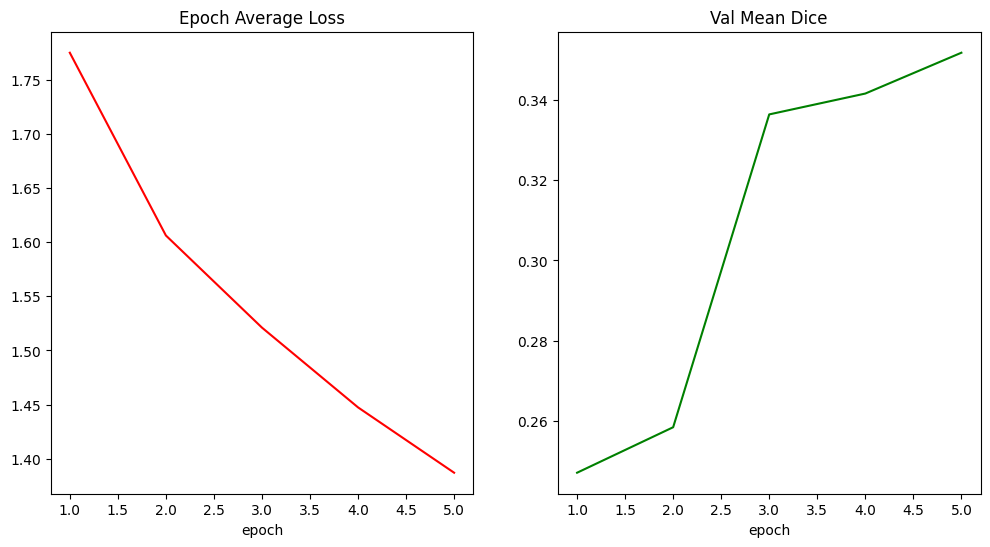

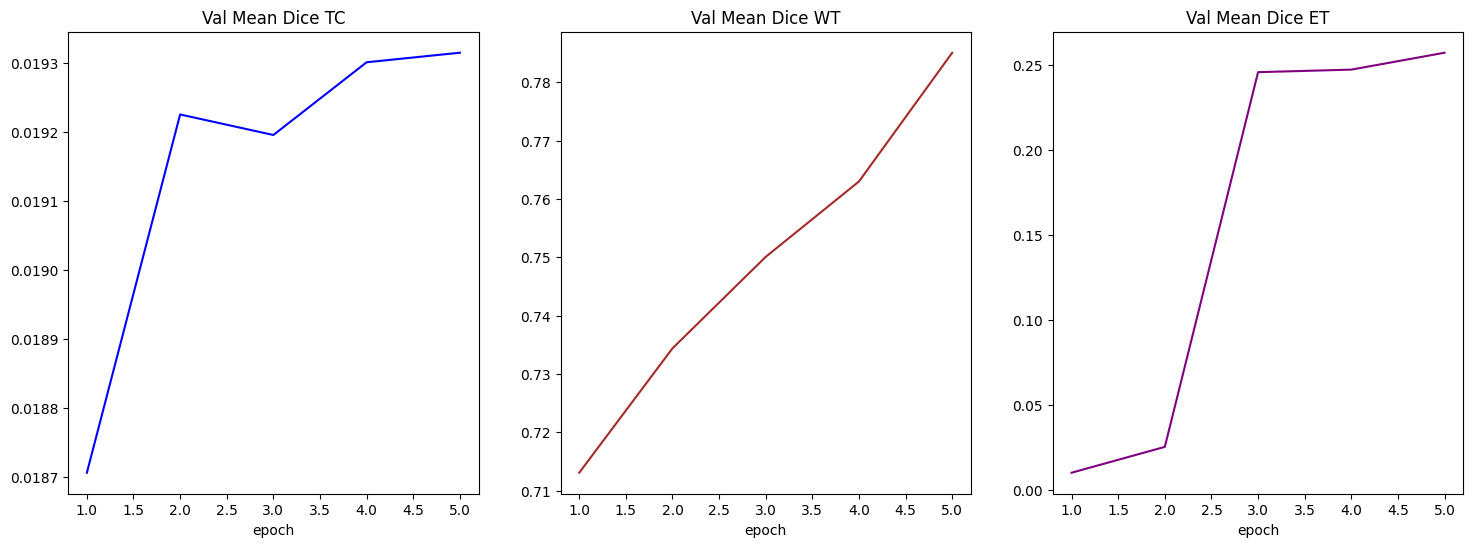

In [22]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

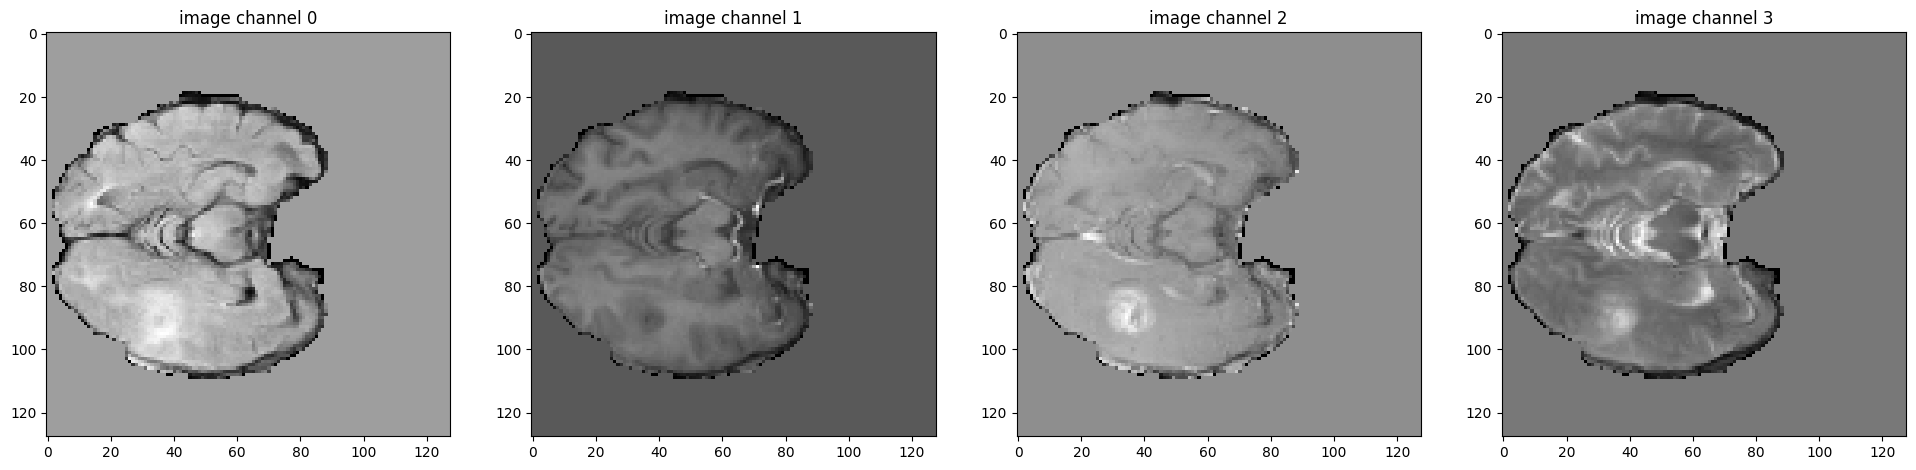

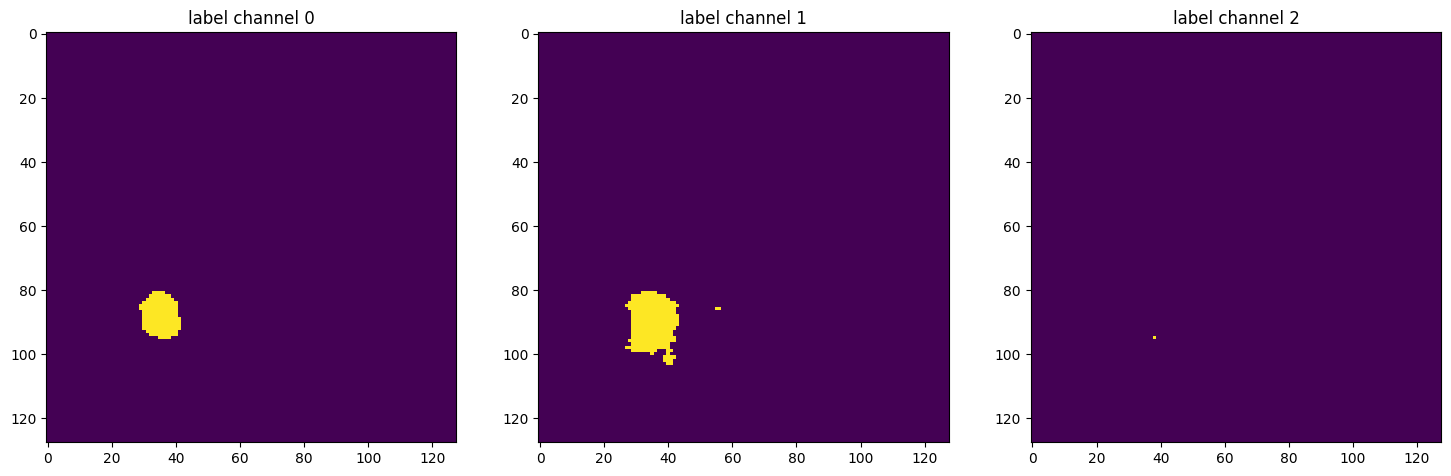

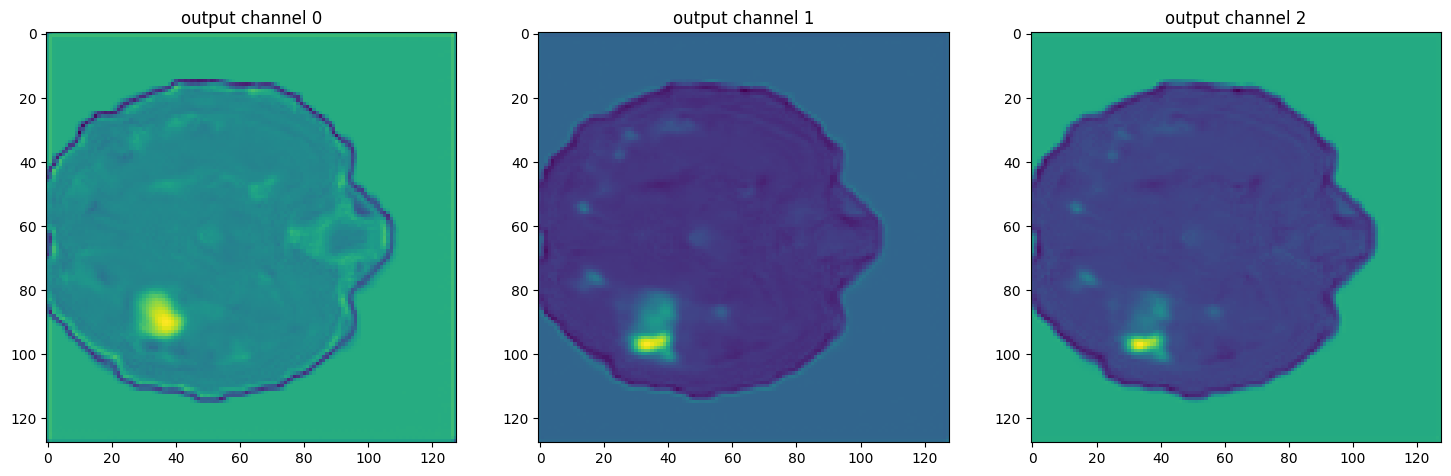

In [23]:

newModel.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model.pth"))
)
newModel.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    val_output = newModel(val_input)
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 20].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        out_tensor = torch.sigmoid(val_output[0, i, :, :, 20]).detach().cpu()
        plt.imshow(out_tensor)
    plt.show()